In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import talib
from talib import RSI, BBANDS, MACD, ATR

MONTH = 21
YEAR = 12 * MONTH
START = '2010-01-01'
END = '2017-12-31'
sns.set_style('darkgrid')
idx = pd.IndexSlice
percentiles = [.001, .01, .02, .03, .04, .05]
percentiles += [1-p for p in percentiles[::-1]]
T = [1, 5, 10, 21, 42, 63]

In [2]:
# Loading Quandl Wiki Stock Prices & Meta Data
DATA_STORE = 'data/assets.h5'
ohlcv = ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']

with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices'].loc[idx[START:END, :], ohlcv]
              .rename(columns=lambda x: x.replace('adj_', '')).swaplevel().sort_index())
    metadata = (store['us_equities/stocks'].loc[:, ['marketcap', 'sector']])

In [3]:
pd.concat([prices.head(), prices.tail()])

open      close        low       high     volume
ticker date                                                             
A      2010-01-04  21.415535  21.354133  21.239108  21.579273  2729300.0
       2010-01-05  21.292732  21.122172  20.985724  21.299554  2994300.0
       2010-01-06  21.047125  21.047125  20.985724  21.149461  2320300.0
       2010-01-07  20.999368  21.019836  20.808341  21.026658  2214000.0
       2010-01-08  20.903855  21.013013  20.740117  21.047125  2670900.0
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209585.0
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213951.0
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227325.0
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162070.0
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222040.0

In [4]:
prices.volume /= 1e3
prices.index.names = ['symbol', 'date']
metadata.index.name = 'symbol'

In [5]:
# Remove stocks with insufficient observations
min_obs = 7 * YEAR
nobs = prices.groupby(level='symbol').size()
keep = nobs[nobs > min_obs].index
prices = prices.loc[idx[keep, :], :]

# Align price and meta data
metadata = metadata[~metadata.index.duplicated() & metadata.sector.notnull()]
metadata.sector = metadata.sector.str.lower().str.replace(' ', '_')
shared = (prices.index.get_level_values('symbol').unique().intersection(metadata.index))
metadata = metadata.loc[shared, :]
prices = prices.loc[idx[shared, :], :]

In [30]:
metadata.groupby('sector').sum().sort_values(by='marketcap', ascending=True)

,marketcap
sector,
consumer_durables,2.738500e+11
transportation,5.649100e+11
miscellaneous,8.874000e+11
basic_industries,8.937500e+11
consumer_non-durables,1.501720e+12
public_utilities,1.541190e+12
energy,1.711440e+12
capital_goods,1.817080e+12
health_care,3.267450e+12


In [10]:
# Limit universe to 1,000 stocks with highest market cap
universe = metadata.marketcap.nlargest(1000).index
prices = prices.loc[idx[universe, :], :]
metadata = metadata.loc[universe]
metadata.sector.value_counts()

consumer_services        187
finance                  168
technology               116
health_care              103
capital_goods             94
basic_industries          67
public_utilities          66
consumer_non-durables     61
energy                    51
consumer_durables         36
miscellaneous             28
transportation            23
Name: sector, dtype: int64

In [11]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2004775 entries, ('AAPL', Timestamp('2010-01-04 00:00:00')) to ('NTCT', Timestamp('2017-12-29 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    2004775 non-null  float64
 1   close   2004775 non-null  float64
 2   low     2004775 non-null  float64
 3   high    2004775 non-null  float64
 4   volume  2004775 non-null  float64
dtypes: float64(5)
memory usage: 84.9+ MB


In [12]:
metadata.info()
metadata.tail()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, AAPL to NTCT
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  1000 non-null   float64
 1   sector     1000 non-null   object 
dtypes: float64(1), object(1)
memory usage: 23.4+ KB


,marketcap,sector
symbol,,
FIBK,2.410000e+09,finance
MDP,2.410000e+09,consumer_services
MGLN,2.400000e+09,health_care
ITRI,2.380000e+09,capital_goods
NTCT,2.380000e+09,technology


In [13]:
# Rank assets by Rolling Average Dollar Volume
prices['dollar_vol'] = prices[['close', 'volume']].prod(1).div(1e3)

# 21d MA with 1 trading month
dollar_vol_ma = (prices.dollar_vol.unstack('symbol').rolling(window=21, min_periods=1).mean())
dollar_vol_ma.tail()

symbol,AAPL,AMZN,GOOGL,MSFT,JPM,XOM,JNJ,V,BAC,WFC,...,CLF,EE,JACK,NNI,TROX,FIBK,MDP,MGLN,ITRI,NTCT
date,,,,,,,,,,,,,,,,,,,,,
2017-12-27,4773.981172,3876.059546,1678.988130,2008.493973,1615.510169,931.822708,820.703792,1074.076538,2366.495901,1332.360674,...,75.451622,12.524655,102.390126,5.553589,60.819626,9.807255,37.922555,16.133700,24.832113,35.345407
2017-12-28,4694.413073,3724.225210,1642.603672,1963.256411,1573.230028,925.161393,802.404440,1078.590957,2291.780910,1297.209089,...,74.621444,12.462259,99.935894,5.568057,57.582267,9.641455,34.245981,15.937043,24.868890,33.739124
2017-12-29,4571.883552,3362.807779,1565.370748,1932.462189,1514.818079,921.750678,797.322705,1031.171032,2189.194870,1249.101322,...,74.268476,12.015000,95.415511,5.395868,53.048666,9.180718,32.617539,15.295468,24.798635,31.764210
2017-08-07,4455.296658,3271.678665,1520.575442,1867.307379,1432.090547,879.867905,757.435437,968.292349,2075.482479,1224.058019,...,74.589541,11.803360,80.844332,5.233405,49.381328,9.148248,31.511530,15.376514,24.494609,30.783422
2017-04-14,4333.371051,3194.840504,1501.757511,1838.016890,1400.698712,866.474826,753.425480,944.652702,1991.096398,1197.833963,...,73.913994,11.752013,78.344440,5.277082,49.132825,9.061540,29.783921,13.133072,24.912334,30.846009


In [14]:
# Rank stocks by moving average
prices['dollar_vol_rank'] = (dollar_vol_ma.rank(axis=1, ascending=False).stack('symbol').swaplevel())

prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2004775 entries, ('AAPL', Timestamp('2010-01-04 00:00:00')) to ('NTCT', Timestamp('2017-12-29 00:00:00'))
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             2004775 non-null  float64
 1   close            2004775 non-null  float64
 2   low              2004775 non-null  float64
 3   high             2004775 non-null  float64
 4   volume           2004775 non-null  float64
 5   dollar_vol       2004775 non-null  float64
 6   dollar_vol_rank  2004775 non-null  float64
dtypes: float64(7)
memory usage: 115.5+ MB


In [15]:
prices.tail()

open  close     low    high   volume  dollar_vol  \
symbol date                                                            
NTCT   2017-12-22  31.40  31.55  31.050  31.725  568.152   17.925196   
       2017-12-26  31.40  31.05  30.800  31.550  404.679   12.565283   
       2017-12-27  31.10  31.05  30.800  31.300  278.693    8.653418   
       2017-12-28  31.05  30.65  30.475  31.050  264.128    8.095523   
       2017-12-29  30.70  30.45  30.250  30.800  393.595   11.984968   

                   dollar_vol_rank  
symbol date                         
NTCT   2017-12-22            666.0  
       2017-12-26            668.0  
       2017-12-27            675.0  
       2017-12-28            687.0  
       2017-12-29            701.0

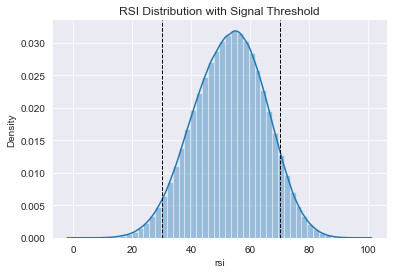

In [16]:
# Compute RSI(Relative Strength Index)
prices['rsi'] = prices.groupby(level='symbol').close.apply(RSI)
ax = sns.distplot(prices.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
sns.despine()

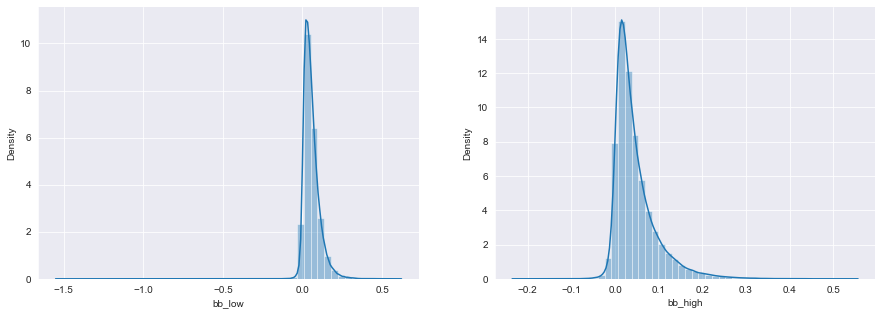

In [17]:
# Compute Bollinger Bands
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

prices = (prices.join(prices.groupby(level='symbol').close.apply(compute_bb)))
prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
sns.despine()

In [18]:
# Compute Average True Range
prices['NATR'] = prices.groupby(level='symbol', group_keys=False).apply(lambda x:
                                                        talib.NATR(x.high, x.low, x.close))
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

prices['ATR'] = (prices.groupby('symbol', group_keys=False).apply(compute_atr))

# Compute MACD(Moving Average Convergence/Divergence)
prices['PPO'] = prices.groupby(level='symbol').close.apply(talib.PPO) # Percentage Price Oscillator(Momentum)

def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

prices['MACD'] = (prices.groupby('symbol', group_keys=False).close.apply(compute_macd))

# Combine Price and Meta Data
metadata.sector = pd.factorize(metadata.sector)[0].astype(int)
prices = prices.join(metadata[['sector']])

In [19]:
prices.tail()

open  close     low    high   volume  dollar_vol  \
symbol date                                                            
NTCT   2017-12-22  31.40  31.55  31.050  31.725  568.152   17.925196   
       2017-12-26  31.40  31.05  30.800  31.550  404.679   12.565283   
       2017-12-27  31.10  31.05  30.800  31.300  278.693    8.653418   
       2017-12-28  31.05  30.65  30.475  31.050  264.128    8.095523   
       2017-12-29  30.70  30.45  30.250  30.800  393.595   11.984968   

                   dollar_vol_rank        rsi   bb_high    bb_low      NATR  \
symbol date                                                                   
NTCT   2017-12-22            666.0  61.741125  0.015633  0.078165  2.711828   
       2017-12-26            668.0  55.773339  0.031844  0.064335  2.731209   
       2017-12-27            675.0  55.773339  0.030640  0.063999  2.651144   
       2017-12-28            687.0  51.183203  0.038697  0.051319  2.627906   
       2017-12-29            701.0  49.011255  0.043142  0.045558  2.585243   

                        ATR       PPO      MACD  sector  
symbol date                                              
NTCT   2017-12-22  0.105730 -0.566611  0.239059       0  
       2017-12-26  0.073142 -0.198381  0.259566       0  
       2017-12-27 -0.034279 -0.012578  0.271750       0  
       2017-12-28 -0.110880  0.270304  0.230382       0  
       2017-12-29 -0.189725  0.530498  0.170974       0

In [42]:
# Historical Returns
by_sym = prices.groupby(level='symbol').close.fillna(float("-inf"))
for t in T:
    prices[f'r{t:02}'] = by_sym.pct_change(t)

# Daily historical return deciles
for t in T:
    prices[f'r{t:02}dec'] = (prices[f'r{t:02}'].groupby(level='date').apply(lambda x: pd.qcut(x,q=10,
                                                      labels=False, duplicates='drop')))

# Daily sector return deciles
for t in T:
    prices[f'r{t:02}q_sector'] = (prices.groupby(['date', 'sector'])[f'r{t:02}']
                                  .transform(lambda x: pd.qcut(x, q=5, labels=False, duplicates='drop')))

# Compute Forward Returns
for t in [1, 5, 21]:
    prices[f'r{t:02}_fwd'] = prices.groupby(level='symbol')[f'r{t:02}'].shift(-t)

prices[[f'r{t:02}' for t in T]].describe()

,r01,r05,r10,r21,r42,r63
count,2.004774e+06,2.004770e+06,2.004765e+06,2.004754e+06,2.004733e+06,2.004712e+06
mean,6.586866e-04,3.258556e-03,6.394677e-03,1.330321e-02,2.629577e-02,3.904280e-02
std,1.102832e-01,2.458175e-01,3.437509e-01,4.892082e-01,6.884867e-01,8.564652e-01
min,-9.981835e-01,-9.982033e-01,-9.981934e-01,-9.982273e-01,-9.982566e-01,-9.982944e-01
25%,-8.103131e-03,-1.738473e-02,-2.339956e-02,-3.198326e-02,-3.960659e-02,-4.489451e-02
50%,6.502272e-04,3.634941e-03,6.975585e-03,1.439895e-02,2.708018e-02,3.868220e-02
75%,9.506371e-03,2.437091e-02,3.697024e-02,5.895998e-02,9.212237e-02,1.201739e-01
max,1.155272e+02,1.150669e+02,1.200070e+02,1.209208e+02,1.246000e+02,1.320833e+02


In [49]:
prices.tail(10)

open  close     low    high    volume  dollar_vol  \
symbol date                                                             
NTCT   2017-12-15  30.00  30.05  29.650  30.250  2330.772   70.039699   
       2017-12-18  30.30  31.05  30.055  31.100  2578.571   80.064630   
       2017-12-19  31.05  30.90  30.550  31.250   704.168   21.758791   
       2017-12-20  31.15  30.85  30.750  31.400   536.858   16.562069   
       2017-12-21  30.90  31.30  30.150  31.450   776.135   24.293025   
       2017-12-22  31.40  31.55  31.050  31.725   568.152   17.925196   
       2017-12-26  31.40  31.05  30.800  31.550   404.679   12.565283   
       2017-12-27  31.10  31.05  30.800  31.300   278.693    8.653418   
       2017-12-28  31.05  30.65  30.475  31.050   264.128    8.095523   
       2017-12-29  30.70  30.45  30.250  30.800   393.595   11.984968   

                   dollar_vol_rank        rsi   bb_high    bb_low  ...  \
symbol date                                                        ...   
NTCT   2017-12-15            679.0  49.039685  0.052398  0.035500  ...   
       2017-12-18            653.0  58.057780  0.024222  0.063795  ...   
       2017-12-19            652.0  56.444245  0.030116  0.059049  ...   
       2017-12-20            655.0  55.886688  0.031118  0.057532  ...   
       2017-12-21            658.0  59.741108  0.020012  0.070484  ...   
       2017-12-22            666.0  61.741125  0.015633  0.078165  ...   
       2017-12-26            668.0  55.773339  0.031844  0.064335  ...   
       2017-12-27            675.0  55.773339  0.030640  0.063999  ...   
       2017-12-28            687.0  51.183203  0.038697  0.051319  ...   
       2017-12-29            701.0  49.011255  0.043142  0.045558  ...   

                   r63dec  r01q_sector  r05q_sector  r10q_sector  r21q_sector  \
symbol date                                                                     
NTCT   2017-12-15     0.0          0.0          2.0          0.0          2.0   
       2017-12-18     0.0          4.0          4.0          1.0          3.0   
       2017-12-19     0.0          2.0          4.0          2.0          3.0   
       2017-12-20     1.0          2.0          4.0          4.0          2.0   
       2017-12-21     1.0          4.0          4.0          4.0          2.0   
       2017-12-22     1.0          4.0          4.0          4.0          3.0   
       2017-12-26     1.0          0.0          4.0          4.0          3.0   
       2017-12-27     1.0          1.0          3.0          4.0          3.0   
       2017-12-28     0.0          0.0          2.0          4.0          2.0   
       2017-12-29     0.0          2.0          0.0          3.0          0.0   

                   r42q_sector  r63q_sector   r01_fwd   r05_fwd  r21_fwd  
symbol date                                                               
NTCT   2017-12-15          0.0          0.0  0.033278  0.049917      NaN  
       2017-12-18          1.0          0.0 -0.004831  0.000000      NaN  
       2017-12-19          1.0          0.0 -0.001618  0.004854      NaN  
       2017-12-20          1.0          0.0  0.014587 -0.006483      NaN  
       2017-12-21          2.0          0.0  0.007987 -0.027157      NaN  
       2017-12-22          2.0          0.0 -0.015848       NaN      NaN  
       2017-12-26          2.0          0.0  0.000000       NaN      NaN  
       2017-12-27          2.0          0.0 -0.012882       NaN      NaN  
       2017-12-28          3.0          0.0 -0.006525       NaN      NaN  
       2017-12-29          4.0          0.0       NaN       NaN      NaN  

[10 rows x 36 columns]

In [50]:
# Remove outliers
outliers = prices[prices.r01 > 1].index.get_level_values('symbol').unique()
prices = prices.drop(outliers, level='symbol')

# Create time and sector dummy variables
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month
prices['weekday'] = prices.index.get_level_values('date').weekday
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1926804 entries, ('AAPL', Timestamp('2010-01-04 00:00:00')) to ('NTCT', Timestamp('2017-12-29 00:00:00'))
Data columns (total 39 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             1926804 non-null  float64
 1   close            1926804 non-null  float64
 2   low              1926804 non-null  float64
 3   high             1926804 non-null  float64
 4   volume           1926804 non-null  float64
 5   dollar_vol       1926804 non-null  float64
 6   dollar_vol_rank  1926804 non-null  float64
 7   rsi              1913350 non-null  float64
 8   bb_high          1908545 non-null  float64
 9   bb_low           1908543 non-null  float64
 10  NATR             1913350 non-null  float64
 11  ATR              1913350 non-null  float64
 12  PPO              1902779 non-null  float64
 13  MACD             1895091 non-null  float64
 14  sector           1926804 non-null  int

In [51]:
prices.drop(['open', 'close', 'low', 'high', 'volume'], axis=1).to_hdf('data/data.h5', 'model_data')

In [53]:
pd.concat([prices.head(), prices.tail()])

open      close        low       high      volume  \
symbol date                                                                 
AAPL   2010-01-04  27.428730  27.503268  27.293790  27.566240  123432.400   
       2010-01-05  27.579091  27.550818  27.405597  27.706320  150476.200   
       2010-01-06  27.550818  27.112585  27.084312  27.660055  138040.000   
       2010-01-07  27.212826  27.062465  26.865839  27.244955  119282.800   
       2010-01-08  27.026481  27.242385  26.867124  27.244955  111902.700   
NTCT   2017-12-22  31.400000  31.550000  31.050000  31.725000     568.152   
       2017-12-26  31.400000  31.050000  30.800000  31.550000     404.679   
       2017-12-27  31.100000  31.050000  30.800000  31.300000     278.693   
       2017-12-28  31.050000  30.650000  30.475000  31.050000     264.128   
       2017-12-29  30.700000  30.450000  30.250000  30.800000     393.595   

                    dollar_vol  dollar_vol_rank        rsi   bb_high  \
symbol date                                                            
AAPL   2010-01-04  3394.794352              1.0        NaN       NaN   
       2010-01-05  4145.742393              1.0        NaN       NaN   
       2010-01-06  3742.621292              1.0        NaN       NaN   
       2010-01-07  3228.086599              1.0        NaN       NaN   
       2010-01-08  3048.496380              2.0        NaN       NaN   
NTCT   2017-12-22    17.925196            666.0  61.741125  0.015633   
       2017-12-26    12.565283            668.0  55.773339  0.031844   
       2017-12-27     8.653418            675.0  55.773339  0.030640   
       2017-12-28     8.095523            687.0  51.183203  0.038697   
       2017-12-29    11.984968            701.0  49.011255  0.043142   

                     bb_low  ...  r10q_sector  r21q_sector  r42q_sector  \
symbol date                  ...                                          
AAPL   2010-01-04       NaN  ...          NaN          NaN          NaN   
       2010-01-05       NaN  ...          NaN          NaN          NaN   
       2010-01-06       NaN  ...          NaN          NaN          NaN   
       2010-01-07       NaN  ...          NaN          NaN          NaN   
       2010-01-08       NaN  ...          NaN          NaN          NaN   
NTCT   2017-12-22  0.078165  ...          4.0          3.0          2.0   
       2017-12-26  0.064335  ...          4.0          3.0          2.0   
       2017-12-27  0.063999  ...          4.0          3.0          2.0   
       2017-12-28  0.051319  ...          4.0          2.0          3.0   
       2017-12-29  0.045558  ...          3.0          0.0          4.0   

                   r63q_sector   r01_fwd   r05_fwd   r21_fwd  year  month  \
symbol date                                                                 
AAPL   2010-01-04          NaN  0.001729 -0.018223 -0.069062  2010      1   
       2010-01-05          NaN -0.015906 -0.031066 -0.104161  2010      1   
       2010-01-06          NaN -0.001849 -0.001517 -0.073518  2010      1   
       2010-01-07          NaN  0.006648 -0.005461 -0.078165  2010      1   
       2010-01-08          NaN -0.008822 -0.028540 -0.074488  2010      1   
NTCT   2017-12-22          0.0 -0.015848       NaN       NaN  2017     12   
       2017-12-26          0.0  0.000000       NaN       NaN  2017     12   
       2017-12-27          0.0 -0.012882       NaN       NaN  2017     12   
       2017-12-28          0.0 -0.006525       NaN       NaN  2017     12   
       2017-12-29          0.0       NaN       NaN       NaN  2017     12   

                   weekday  
symbol date                 
AAPL   2010-01-04        0  
       2010-01-05        1  
       2010-01-06        2  
       2010-01-07        3  
       2010-01-08        4  
NTCT   2017-12-22        4  
       2017-12-26        1  
       2017-12-27        2  
       2017-12-28        3  
       2017-12-29        4  

[10 rows x 39 columns]